In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [7]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_jump=2
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [8]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt


def simulate_ems_step1(ems, loc, T=100, dt=1):
    y_grid_pre = y_grid[:loc+1]
    periods = int(T/dt)
    yt = np.zeros(periods)
    et = np.zeros(periods)
    y = 1.1
    for t in range(periods):
        if y < y_grid[loc]:
            e_i = np.interp(y, y_grid_pre, ems)
            et[t] = e_i
            yt[t] = y
            y  = y + e_i*np.mean(θ_list)*dt
    return et, yt

In [41]:
def solve_baseline(y_grid, numy_bar, ems_star, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy = args
    args_list = []
    for γ3_i in γ3_list:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, ξa, ξw)
        args_iter = (y_grid, args_func, 2000, 1e-7, 3)
        args_list.append(args_iter)
  
    res_list = ode_y_parallel(args_list)
    
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['φ']

#     ems_star = solu['ems']
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    g_list = np.ones((len(γ3_list), len(y_grid_cap)))
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity*((dmg_weight*ϕ_list[:, numy_bar])@g_list)
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [10]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [479]:
from multiprocessing import Pool

# test for ξ_p = 2
# baseline
ξa = 0.01
ξw = 100_000
ξp = 0.3
hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [480]:
# args_list = []
# for y_tilde in jump_interval[-1:]:
#     for γ3_i in γ3_list[1:]:
#         args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw)
#         args_iter = (y_grid, args_func, 2000, 1e-7, 3)
#         args_list.append(args_iter)

args_list = []
for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, ξa, ξw)
    args_iter = (y_grid, args_func, 2000, 1e-7, 3)
    args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        

In [481]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 446,	 ode error: 0.0004216689230812226,	 ft error: 9.769380622988895e-08
episode: 448,	 ode error: 0.00044266604576050084,	 ft error: 9.800122491299135e-08
episode: 447,	 ode error: 0.0004324177668610721,	 ft error: 9.799654835755216e-08
episode: 443,	 ode error: 0.000352893272220621,	 ft error: 9.897145873220363e-08
episode: 440,	 ode error: 0.00032665761561818246,	 ft error: 9.77689934937113e-08
episode: 449,	 ode error: 0.00045354556509139693,	 ft error: 9.775757803254237e-08
episode: 444,	 ode error: 0.00041023290399282847,	 ft error: 9.984630633397273e-08
episode: 442,	 ode error: 0.00034008755949746505,	 ft error: 9.73151551934374e-08
episode: 452,	 ode error: 0.0005429574145560251,	 ft error: 9.965658698263269e-08
episode: 450,	 ode error: 0.00046797822674074854,	 ft error: 9.73090855301469e-08
episode: 2000,	 ode error: 7.17991155827491e-05,	 ft error: 8.541033232371357e-06
episode: 450,	 ode error: 0.0005075134646140601,	 ft error: 9.950697688054788e-08
episode: 451,	

'00h01m09s'

In [197]:
# pickle.dump(res_list, open("../data/damage_prep_40_0.01.p", "wb"))

In [198]:
# res_dict = pickle.load(open('../../damage_prep_40_tight.p', 'rb'))

# ϕ_ref = res_dict['φ_ref']
# ems_ref = res_dict['ems_ref']
# res_list = res_dict['res_list']
# ems_list = res_dict['ems_list']
# ϕ_list = res_dict['φ_list']

In [434]:
# construct ϕ_m
pre_jump = np.arange(y_min, 2 + hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [18]:
# res_test = res_list # + res_list_ex

# ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
# ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

# count = 0
# for i, y_tilde in enumerate(jump_interval):
#     ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
#     ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
#     for j in range(len(γ3_list[1:])):
#         ϕ_ref[j+1, i + len(prepre_jump)] = res_test[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
#         ems_ref[j+1, i + len(prepre_jump)] = res_test[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [134]:
# ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
# ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
# for i, y_tilde in enumerate(jump_interval):
#     ϕ_list[i, 0] = solution_low['φ']
#     ems_list[i, 0] = solution_low['ems']
#     for j in range(len(γ3_list[1:])):
#         ϕ_list[i, j + 1] = res_test[i*len(γ3_list[1:]) + j]['φ']
#         ems_list[i, j + 1] = res_test[i*len(γ3_list[1:]) + j]['ems']

In [482]:
ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(γ3_list), len(y_grid)))

for j in range(len(γ3_list)):
    ϕ_list[j ] = res_list[ j]['φ']
    ems_list[ j ] = res_list[ j]['ems']

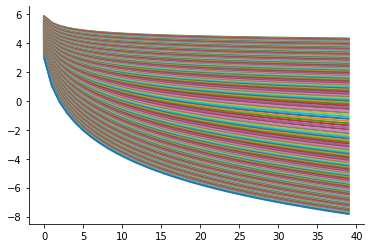

In [483]:
plt.plot(ϕ_list)
plt.show()

In [19]:
# res_dict = dict(res_list=res_test, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
# res_dict = dict(res_list=res_list, ϕ_list=ϕ_list, ems_list=ems_list)
# pickle.dump(res_dict, open("../data/damage_prep_40_5.p", "wb"))

In [20]:
# res_dict_long = pickle.load(open('../data/damage_prep_40.p', 'rb'))

# ϕ_ref = res_dict_long['φ_ref']
# ems_ref = res_dict_long['ems_ref']
# res_list = res_dict_long['res_list']
# ems_list = res_dict_long['ems_list']
# ϕ_list = res_dict_long['φ_list']

In [202]:
def solve_baseline_prep(y_grid, ems_star, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3, ȳ, dmg_weight, ξp, ξa, ξw, σy = args
#     ems_star = solu['ems']
    # solve for HJB with jump function
#     y_grid_cap = y_grid[:numy_bar+1]
    numy_bar = len(pre_jump)
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    πᶜo = np.ones((len(θ_list), len(y_grid)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [484]:
ϕ_list.shape

(40, 201)

In [485]:
ems_list.shape

(40, 201)

In [486]:
me_list = np.zeros((len(γ3_list), len(y_grid)))
ratio_list = np.zeros((len(γ3_list), len(y_grid)))

for i in range(len(γ3_list)):
    args_baseline = (δ, η, θ_list, γ1, γ2, γ3_list[i], 2, dmg_weight, 100_000, 100_000, 100_000, σy )
    ems_star = ems_list[i]
    me_baseline = solve_baseline_prep(y_grid, ems_star, args_baseline, ϵ=1)
    me_list[i] = me_baseline[0]
    ratio_list[i] = me_baseline[1]

episode: 3000,	 ode error: 0.00010792535129990066,	 ft error: 8.505443903850107e-06
episode: 1571,	 ode error: 0.00010462467056889663,	 ft error: 9.901507169729484e-09
episode: 3000,	 ode error: 0.0002621635750651788,	 ft error: 8.503549766558649e-07
episode: 1548,	 ode error: 0.00032289842212284564,	 ft error: 9.981868775987834e-09
episode: 1530,	 ode error: 0.00039294998598820435,	 ft error: 9.939838507833088e-09
episode: 1512,	 ode error: 0.0004531924863641762,	 ft error: 9.979702397799883e-09
episode: 1495,	 ode error: 0.000506806219207484,	 ft error: 9.906389042413366e-09
episode: 1474,	 ode error: 0.0005556692664499541,	 ft error: 9.941643952515733e-09
episode: 1459,	 ode error: 0.0005481468609164555,	 ft error: 9.974892467567997e-09
episode: 1440,	 ode error: 0.000586539269410033,	 ft error: 9.985721582950191e-09
episode: 1420,	 ode error: 0.0006225374466900177,	 ft error: 9.92953985701206e-09
episode: 1397,	 ode error: 0.0006576721792018979,	 ft error: 9.961440561312429e-09
epi

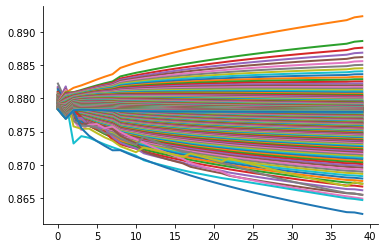

In [487]:
plt.plot(ratio_list)
plt.show()

In [488]:
1- ratio_list.max(), 1- ratio_list.min(), ratio_list.shape

(0.10761865350219246, 0.13741568629520085, (40, 201))

# Step 2: HJB

In [489]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [490]:
ξa = 0.01
ξp = 0.3
ξw = 100_000
σy=1.2*np.mean(θ_list)

numy_bar = len(pre_jump) -1
y_grid_cap = y_grid[:numy_bar+1]


r1=1.5
r2=2.5

y_lower = 1.5
intensity = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
# intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

# AA = 30
# intensity =( 0.5*AA*(y_grid_cap-1.5)**2)*( y_grid_cap > 1.5)
dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2

ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]


dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)

ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)

ϕ = ϕ_bound[:numy_bar+1]

# bound_neumann1 = (cert_equiv[numy_bar] - cert_equiv[numy_bar-1])/dy
# bound_neumann2 = (cert_equiv[numy_bar] -2*cert_equiv[numy_bar-1] + cert_equiv[numy_bar-2])/(dy**2)
# ϕ_bound = np.average(ϕ_list2, weights=dmg_weight, axis=0)

# bound_set=(bound_neumann1, bound_neumann2)

tol= 1e-8
ϵ = 0.5
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, (0,0),  False, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    
    if σy == 0:
        ems_new = - η/(temp*(θ_list@πᶜ))
    else:
        a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@πᶜ)*temp
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    ϕ_ref = np.zeros((len(γ3_list), len(y_grid_cap)))
    for i in range(len(γ3_list)):
        ϕ_ref[i] = ϕ_list[i, numy_bar]
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity*(dmg_weight@(g_list*ϕ_ref))
    # solver
    
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ,(False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 11.833043498623388,	 ft error: 0.5291371323875538
episode: 2,	 ode error: 3.4325501479162512,	 ft error: 0.45153581633126416
episode: 3,	 ode error: 1.1558785795631503,	 ft error: 0.35060027225811996
episode: 4,	 ode error: 0.5383563956984571,	 ft error: 0.26010410109494475
episode: 5,	 ode error: 0.464490182081508,	 ft error: 0.1955153012033184
episode: 6,	 ode error: 0.42182252196654846,	 ft error: 0.1519426660529381
episode: 7,	 ode error: 0.40649144482303107,	 ft error: 0.12265862212538603
episode: 8,	 ode error: 0.41186123809524033,	 ft error: 0.10267706949752609
episode: 9,	 ode error: 0.4187485005197372,	 ft error: 0.0890998585337005
episode: 10,	 ode error: 0.42566277832058386,	 ft error: 0.0806437203301491
episode: 11,	 ode error: 0.43233319342753435,	 ft error: 0.07435322839295244
episode: 12,	 ode error: 0.4385478417538544,	 ft error: 0.0701791925397226
episode: 13,	 ode error: 0.444186619038636,	 ft error: 0.06656233116053456
episode: 14,	 ode error:

episode: 126,	 ode error: 0.46797816957383603,	 ft error: 0.01854834009634887
episode: 127,	 ode error: 0.46797815877224647,	 ft error: 0.018406920600672283
episode: 128,	 ode error: 0.46797814609322347,	 ft error: 0.018255511705762117
episode: 129,	 ode error: 0.4679781315119259,	 ft error: 0.01809384173545414
episode: 130,	 ode error: 0.46797811497702585,	 ft error: 0.017965841680076533
episode: 131,	 ode error: 0.46797809642110305,	 ft error: 0.017853716794669072
episode: 132,	 ode error: 0.4679780757677891,	 ft error: 0.017732911269288998
episode: 133,	 ode error: 0.4679780529367277,	 ft error: 0.017603167173520617
episode: 134,	 ode error: 0.46797802784701237,	 ft error: 0.017464228593712328
episode: 135,	 ode error: 0.4679780004195556,	 ft error: 0.017315844152994142
episode: 136,	 ode error: 0.467977970578829,	 ft error: 0.01718454282881865
episode: 137,	 ode error: 0.46797793825408557,	 ft error: 0.017079611102568393
episode: 138,	 ode error: 0.46797790338029205,	 ft error: 0.0

episode: 259,	 ode error: 0.46797053060794397,	 ft error: 0.0076667443485733955
episode: 260,	 ode error: 0.46797153845750206,	 ft error: 0.007622981574014531
episode: 261,	 ode error: 0.46797229589177786,	 ft error: 0.007577743603621734
episode: 262,	 ode error: 0.4679728654668124,	 ft error: 0.007530029401097593
episode: 263,	 ode error: 0.46797329542738514,	 ft error: 0.00748516120420728
episode: 264,	 ode error: 0.46797362255062985,	 ft error: 0.0074415999298311775
episode: 265,	 ode error: 0.4679738745800938,	 ft error: 0.007395647161263064
episode: 266,	 ode error: 0.46797407224401444,	 ft error: 0.007350162441885466
episode: 267,	 ode error: 0.46797423088949736,	 ft error: 0.007308080925013449
episode: 268,	 ode error: 0.46797436178107604,	 ft error: 0.007263686049138407
episode: 269,	 ode error: 0.4679744731166994,	 ft error: 0.007217994834739727
episode: 270,	 ode error: 0.4679745708121541,	 ft error: 0.007177215914282442
episode: 271,	 ode error: 0.46797465909970865,	 ft erro

episode: 401,	 ode error: 0.4679847713513189,	 ft error: 0.001955707499407211
episode: 402,	 ode error: 0.4679847687636931,	 ft error: 0.0018978408381151723
episode: 403,	 ode error: 0.4679847601410724,	 ft error: 0.0018406871478653386
episode: 404,	 ode error: 0.4679847455624949,	 ft error: 0.00178429499495536
episode: 405,	 ode error: 0.467984725132396,	 ft error: 0.0017287100175060743
episode: 406,	 ode error: 0.46798469897944983,	 ft error: 0.0016739748338494564
episode: 407,	 ode error: 0.46798466725520604,	 ft error: 0.0016201289715986888
episode: 408,	 ode error: 0.4679846301325536,	 ft error: 0.0015672088171978515
episode: 409,	 ode error: 0.4679845878040306,	 ft error: 0.0015152475852833192
episode: 410,	 ode error: 0.46798454048000543,	 ft error: 0.001464275307144547
episode: 411,	 ode error: 0.4679844883867734,	 ft error: 0.0014143188375523863
episode: 412,	 ode error: 0.4679844317645782,	 ft error: 0.0013654018787789823
episode: 413,	 ode error: 0.4679843708656029,	 ft erro

episode: 553,	 ode error: 0.4679798090868915,	 ft error: 2.427130645799025e-06
episode: 554,	 ode error: 0.4679798086014012,	 ft error: 2.3162018134570417e-06
episode: 555,	 ode error: 0.46797980813364437,	 ft error: 2.2095093417107137e-06
episode: 556,	 ode error: 0.46797980768271885,	 ft error: 2.106905746757093e-06
episode: 557,	 ode error: 0.4679798072477859,	 ft error: 2.008250136853462e-06
episode: 558,	 ode error: 0.4679798068280565,	 ft error: 1.9134077824389806e-06
episode: 559,	 ode error: 0.4679798064227983,	 ft error: 1.8222497430997464e-06
episode: 560,	 ode error: 0.467979806031326,	 ft error: 1.7346525051920025e-06
episode: 561,	 ode error: 0.4679798056529972,	 ft error: 1.6504976372289093e-06
episode: 562,	 ode error: 0.4679798052872163,	 ft error: 1.5696714807944545e-06
episode: 563,	 ode error: 0.4679798049334232,	 ft error: 1.4920648627736455e-06
episode: 564,	 ode error: 0.46797980459109856,	 ft error: 1.4175728022536305e-06
episode: 565,	 ode error: 0.4679798042597

episode: 674,	 ode error: 0.4679797955757237,	 ft error: 2.726279593190384e-07
episode: 675,	 ode error: 0.46797979558939645,	 ft error: 2.7095765098295033e-07
episode: 676,	 ode error: 0.467979795603187,	 ft error: 2.692174314589124e-07
episode: 677,	 ode error: 0.4679797956170692,	 ft error: 2.676102441867556e-07
episode: 678,	 ode error: 0.46797979563102254,	 ft error: 2.6589649237962476e-07
episode: 679,	 ode error: 0.46797979564502507,	 ft error: 2.642976610900405e-07
episode: 680,	 ode error: 0.46797979565905923,	 ft error: 2.6264347674498367e-07
episode: 681,	 ode error: 0.4679797956731034,	 ft error: 2.6102233530167496e-07
episode: 682,	 ode error: 0.4679797956871368,	 ft error: 2.594234507213855e-07
episode: 683,	 ode error: 0.46797979570114157,	 ft error: 2.57786241242286e-07
episode: 684,	 ode error: 0.4679797957150986,	 ft error: 2.5623857435874697e-07
episode: 685,	 ode error: 0.46797979572899046,	 ft error: 2.545909056905771e-07
episode: 686,	 ode error: 0.467979795742800

episode: 803,	 ode error: 0.4679797959697094,	 ft error: 1.676179905985009e-08
episode: 804,	 ode error: 0.4679797959673229,	 ft error: 1.6089451548850775e-08
episode: 805,	 ode error: 0.46797979596498585,	 ft error: 1.543961580807718e-08
episode: 806,	 ode error: 0.46797979596269795,	 ft error: 1.4811744719622766e-08
episode: 807,	 ode error: 0.467979795960458,	 ft error: 1.4205276954726287e-08
episode: 808,	 ode error: 0.4679797959582679,	 ft error: 1.361968493540644e-08
episode: 809,	 ode error: 0.46797979595612593,	 ft error: 1.3054414438329331e-08
episode: 810,	 ode error: 0.4679797959540342,	 ft error: 1.2508943214584178e-08
episode: 811,	 ode error: 0.46797979595198974,	 ft error: 1.198273835711916e-08
episode: 812,	 ode error: 0.4679797959499954,	 ft error: 1.1475284722450851e-08
episode: 813,	 ode error: 0.46797979594804856,	 ft error: 1.0986058285311628e-08
episode: 814,	 ode error: 0.46797979594615063,	 ft error: 1.051455988942962e-08
episode: 815,	 ode error: 0.467979795944

Text(0.5, 0, 'y')

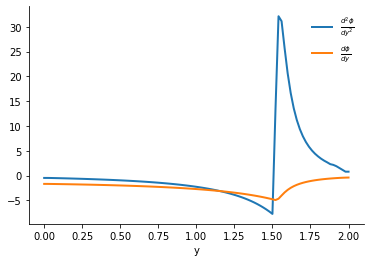

In [491]:
plt.plot(y_grid_cap,dϕdyy, label=r"$\frac{d^2\phi}{dy^2}$")
plt.plot(y_grid_cap,dϕdy, label=r"$\frac{d \phi}{dy}$")
plt.legend()
plt.xlabel('y')
# plt.savefig('derivatives_test.png', facecolor="w", edgecolor='w', dpi=400, bbox_inches='tight')

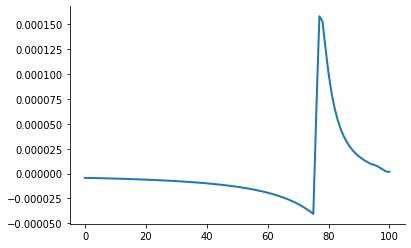

In [492]:
plt.plot(a)

([<matplotlib.lines.Line2D at 0x7f80661a0580>],
 array([0.80176937, 0.80176937]))

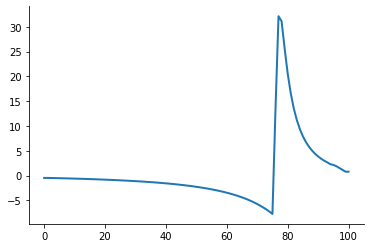

In [493]:
test = derivative_1d(ϕ, 2, dy, (0,0), False, "center")
plt.plot(test), test[-2:]

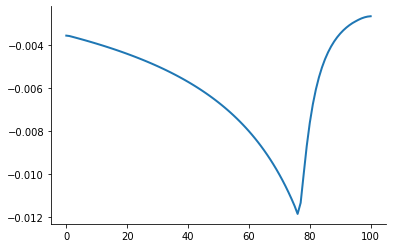

In [494]:
plt.plot(b)

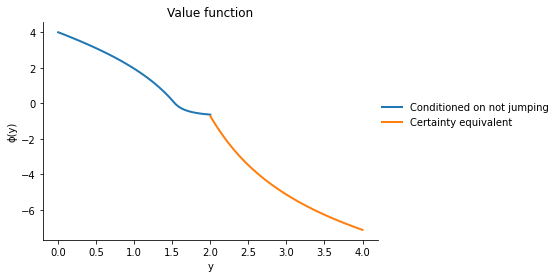

In [495]:
# plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[0,len(prepre_jump):], label="Lowest damage specification value function")
plt.plot(y_grid_cap, solution['φ'], label="Conditioned on not jumping")
# plt.plot(y_grid_cap, solution['φ'])
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
average_desination = np.average(ϕ_ref, axis=0)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:],label="Certainty equivalent")
# plt.plot(y_grid_cap[len(prepre_jump):], average_desination[len(prepre_jump):], label="Average value function at each potential jump point")
# plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[-1, len(prepre_jump):], label="Highest damage specification value function")
plt.title('Value function')
plt.legend(loc=(1,0.5))
plt.xlabel("y")
plt.ylabel("ϕ(y)")
# plt.ylim(0)
# plt.savefig("value_functions_compare.png", facecolor="w", edgecolor="w", dpi=500,  bbox_inches = "tight" )
plt.show()

In [496]:
ϕ_list.shape, solution['φ'][-1], ϕ_bound[numy_bar]

((40, 201), -0.6348794775833667, -0.7225980939488421)

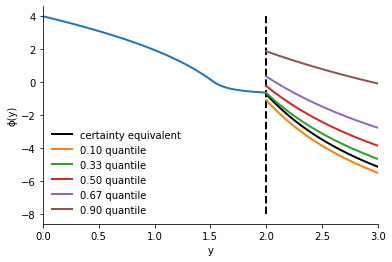

In [497]:
plt.plot(y_grid_cap,solution['φ'])
# plt.plot(y_grid[numy_bar: len(pre_jump)], cert_equiv[numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="certainty equivalent", color="black")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.1, axis=0), label="0.10 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.33, axis=0), label="0.33 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.5, axis=0), label="0.50 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.67, axis=0), label="0.67 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.9, axis=0), label="0.90 quantile")
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
# plt.title("Value function", fontsize=12)
plt.xlabel('y')
plt.vlines(2, -8, 4, color="black", linestyle="dashed")
plt.legend()

plt.ylabel('ϕ(y)')
plt.xlim(0,3)
# plt.savefig('../figures/20_damages/value_2.pdf')
plt.show()

Text(0.5, 0, '$\\phi_m(2)$')

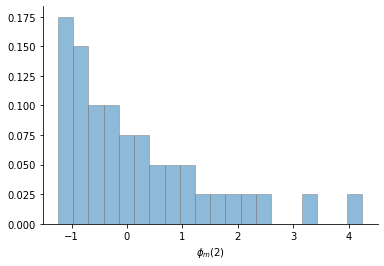

In [498]:
plt.hist(ϕ_list[  :, numy_bar], weights=np.ones_like(ϕ_list[ :, numy_bar])/40, bins=20, alpha=0.5, ec="gray")
plt.xlabel("$\phi_m(2)$")
# plt.savefig('histogram_valuefunc.pdf')

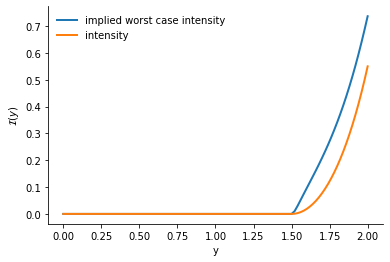

In [499]:
intensity1 = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
worst_case_intensity = dmg_weight@g_list*intensity1
plt.plot(y_grid_cap, worst_case_intensity, label="implied worst case intensity")
plt.plot(y_grid_cap, intensity1, label="intensity")
plt.xlabel('y')
plt.ylabel('$\mathcal{I}(y)$')
plt.legend()
# plt.savefig('../figures/20_damages/intensity_{}_{}.pdf'.format(ξa, ξp))

In [500]:
y_grid[numy_bar], ϕ_list.shape, jump_interval[-1]

(2.0, (40, 201), 2.0000000000000004)

In [501]:
args_base = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, 100_000, 100_000, 100_000, σy)
me, ratio = solve_baseline(y_grid, numy_bar, solution['ems'], args_base, ϵ=2)

episode: 444,	 ode error: 0.0004103151790349341,	 ft error: 9.936129548767288e-08
episode: 442,	 ode error: 0.00037830450017364847,	 ft error: 9.480109882294603e-08
episode: 436,	 ode error: 0.0002887173869677087,	 ft error: 8.960025314290003e-08
episode: 443,	 ode error: 0.0003954637595196542,	 ft error: 9.885752261240555e-08
episode: 438,	 ode error: 0.0003124143753772818,	 ft error: 9.197732338724525e-08
episode: 445,	 ode error: 0.0004237467640618442,	 ft error: 9.777972416931864e-08
episode: 447,	 ode error: 0.0004798736541263282,	 ft error: 9.81874081299831e-08
episode: 446,	 ode error: 0.00046225140339626464,	 ft error: 9.796357858249394e-08
episode: 439,	 ode error: 0.000329563653234409,	 ft error: 9.814531172954351e-08
episode: 450,	 ode error: 0.0004963736382841595,	 ft error: 9.938258127561994e-08
episode: 451,	 ode error: 0.0005150632393383196,	 ft error: 9.93355036745432e-08
episode: 449,	 ode error: 0.0004712747358480984,	 ft error: 9.348665367762503e-08
episode: 441,	 od

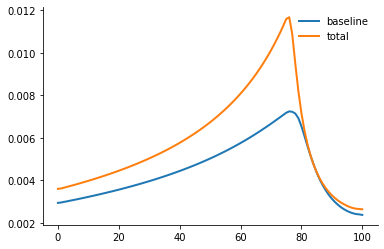

In [502]:
plt.plot(me, label="baseline")
plt.plot(η/solution['ems'], label="total")
plt.legend()

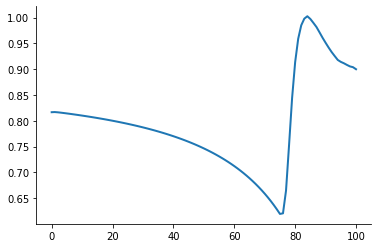

In [503]:
plt.plot(ratio)

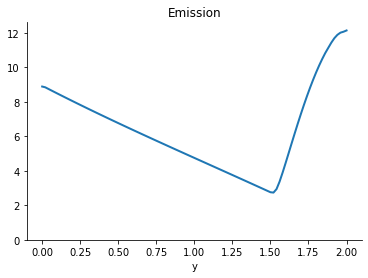

In [504]:
plt.plot(y_grid_cap,solution['ems'])
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
plt.title("Emission", fontsize=12)
plt.ylim(0)
plt.xlabel('y')
# plt.savefig("ems_y.pdf", facecolor="w", edgecolor="w", dpi=400, bbox_inches='tight')
plt.show()

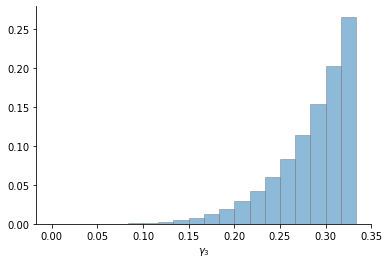

In [505]:
plt.hist(γ3_list, weights=g_list[:,-1]/np.sum(g_list[:,-1]), bins=20, ec="gray", alpha=0.5)
plt.xlabel('$γ_3$')
# plt.savefig("../figures/20_damages/damage_hist.pdf")
plt.show()

In [457]:
dt = 1/4

In [229]:
def no_jump_simulation(ems, g_list, me, dt, r1, r2):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    met = np.zeros(T)
    probt = np.zeros(T)
    gt = np.zeros((T, len(g_list)))
    get_g = interpolate.interp1d(y_grid_cap, g_list)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= 2:
            e_i = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            met[t] = me_i
#             met[t] = me_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            g_list = get_g(y)
            gt[t] = g_list 
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    met = met[np.nonzero(met)]
    probt = probt[np.nonzero(probt)]
    gt = gt[:len(yt)]

    return et, yt, probt, gt, met

In [230]:
def no_jump_simulation_long(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]
    
    return et, yt, probt

In [506]:
simul_no1 = no_jump_simulation(ems=solution['ems'],g_list=solution['g_list'], me=me, dt=dt, r1=1.5, r2=2.5)

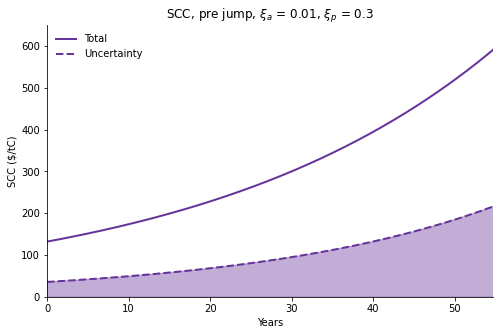

In [507]:
# scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))


fig = plt.figure(figsize=(8,5))

et_star = simul_no1[0]
scc = η/et_star/MCt[:len(et_star)]*1000
scc0 = simul_no1[-1]/MCt[:len(et_star)]*1000 
plt.plot(np.arange(0, len(et_star)*dt, dt), scc, color="rebeccapurple", label="Total")

plt.plot(np.arange(0, len(et_star)*dt, dt), scc -scc0, color="rebeccapurple", linestyle="dashed", label="Uncertainty")
plt.fill_between(np.arange(0, len(et_star)*dt, dt), np.zeros_like(scc), 
                 scc-scc0, color='rebeccapurple', alpha=.4)
plt.xlim(0,54.75)
plt.ylim(0,650)
plt.xlabel("Years")
plt.ylabel("SCC ($/tC)")
plt.legend(loc=2)
plt.title(r'SCC, pre jump, $\xi_a$ = {}, $\xi_p$ = {}'.format(ξa, ξp))
plt.savefig("../figures/20_damages/scc_{}_{}.png".format(ξa, ξp), dpi=500)

In [460]:
((scc - scc0)/scc)[: int(51*4)]

array([0.2008205 , 0.20099026, 0.2011644 , 0.20134288, 0.20152569,
       0.2017128 , 0.20190417, 0.2020998 , 0.20229965, 0.2025037 ,
       0.20268232, 0.20285939, 0.20304078, 0.20322646, 0.20341641,
       0.2036106 , 0.20380902, 0.20401163, 0.20421841, 0.20441102,
       0.2045905 , 0.20477427, 0.20496231, 0.20515459, 0.20535109,
       0.20555179, 0.20575666, 0.20596567, 0.20617773, 0.20635909,
       0.20654472, 0.2067346 , 0.2069287 , 0.207127  , 0.20732947,
       0.20753609, 0.20774684, 0.20796169, 0.20816686, 0.20835382,
       0.20854502, 0.20874042, 0.20894   , 0.20914373, 0.2093516 ,
       0.20956357, 0.20977963, 0.20999974, 0.21020361, 0.21039559,
       0.21059177, 0.21079211, 0.21099658, 0.21120518, 0.21141787,
       0.21163462, 0.21185542, 0.21208025, 0.21228872, 0.21248513,
       0.2126857 , 0.2128904 , 0.2130992 , 0.21331209, 0.21352903,
       0.21375001, 0.213975  , 0.21420397, 0.21442332, 0.21462358,
       0.21482797, 0.21503645, 0.215249  , 0.21546561, 0.21568

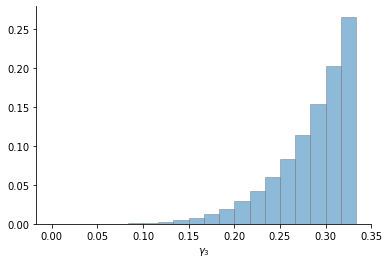

In [508]:
plt.hist(γ3_list, weights=simul_no1[-2][-1]*dmg_weight/np.sum(simul_no1[-2][-1]*dmg_weight), 
         bins=20, ec="gray", alpha=0.5)
plt.xlabel('$γ_3$')
plt.savefig("../figures/20_damages/damage_hist_{}_{}.png".format(ξa, ξp), dpi=500)

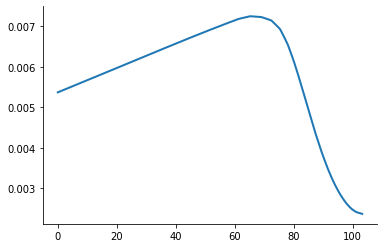

In [509]:
# year = np.arange(0, T-τ, τ)
plt.plot(np.arange(0, len(simul_no1[0])*dt, dt),simul_no1[-1])
# plt.ylim(0)

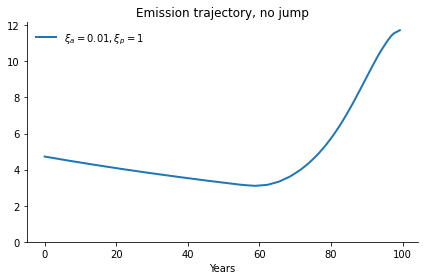

In [463]:
# et_tests = []
# for i in range(len(dmg_weight)):
#     et_test, _, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
#     plt.plot(et_test)
#     et_tests.append(et_test)
    
plt.plot(np.arange(0, len(simul_no1[0])*dt, dt), simul_no1[0], linewidth=2, 
         label=r"$\xi_a = {}, \xi_p={}$".format(ξa, ξp)
        )    
# plt.plot(np.arange(0, len(simul_no1_base[0])*dt, dt), simul_no1_base[0], linewidth=2, label="baseline")    
plt.xlabel('Years')
plt.title("Emission trajectory, no jump", fontsize=12)
plt.legend()
plt.ylim(0)
plt.tight_layout()
# plt.savefig("ems_traj_compare.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

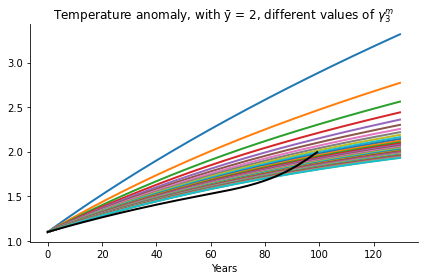

In [464]:
yt_refs = []
for i in range(len(dmg_weight)):
    simul_ref = no_jump_simulation_long(ems_list[ i], dt=dt)
    plt.plot(np.arange(0, len(simul_ref[1])*dt, dt), simul_ref[1], label="$\gamma2$")
    yt_refs.append(simul_ref[1])

# plt.legend()    
plt.plot(np.arange(0, len(simul_no1[1])*dt, dt), simul_no1[1], color="black")
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
plt.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

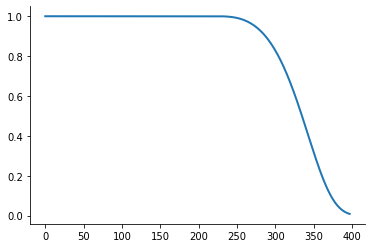

In [465]:
jump_prob = 1 - simul_no1[-3]
integral = np.cumsum(jump_prob)
conti_prob = np.exp(- integral)
plt.plot( conti_prob)

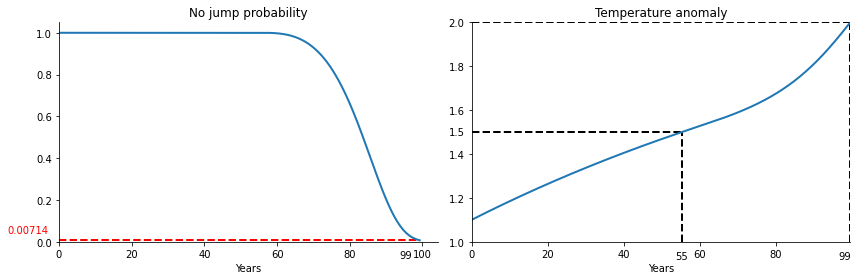

In [466]:
# 1.5, 2.5
import matplotlib.transforms as transforms

yt = simul_no1[1]
T_jump = (np.abs(simul_no1[1]-1.5).argmin())*dt
T_stop = len(simul_no1[0])*dt


Years = np.arange(0, T_stop, dt)
prob_no_jump = np.cumprod(simul_no1[-3])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
# fig.suptitle('{} damage specifications'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, np.cumprod(simul_no1[-3]))
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")

ax1.text(0.95, -0.066, int(T_stop), transform=trans, ha="right", va="center")

ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop, color="black", linestyle="dashed")
ax2.vlines(T_stop, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, T_stop) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax2.text(0,1.5, 1.5, color="black", transform=trans, ha="right", va="center")

ax2.text(1.02, 0.936, int(T_stop), transform=trans, ha="right", va="center")
ax2.text(0.59, 0.936, int(T_jump), transform=trans, ha="right", va="center")

fig.tight_layout()

# fig.savefig("../figures/prob_anomaly.pdf")
# fig.savefig('prob_anomaly_test.pd',dpi=500, facecolor="w", edgecolor="w")

In [467]:
T_jump, len(simul_no1[0])*dt

(55.25, 99.5)

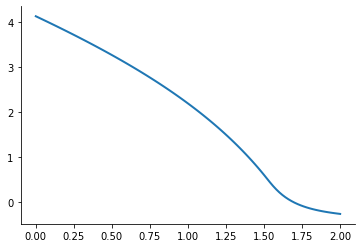

In [468]:
ϕ_list.shape
plt.plot(y_grid_cap, ϕ)

In [469]:
ems_list.shape

(40, 201)

In [245]:
def jump_simulation(ems, ems_list, me, ratio, dt, r1, r2):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
#     ems_list = res_dict['ems_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    Temp_anol = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    ME = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    RATIO = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
        me_i = np.interp(y, y_grid_cap, me)
        ratio_i = np.interp(y, y_grid_cap, ratio)
        intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#         intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        Temp_anol[:, t] = y
        PROB[0, t] = prob_no[t]
        EMS[:, t] = et[t]
        ME[:, t] = me_i
        RATIO[:, t] = ratio_i
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            Temp_anol[0, t] = y
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-y_grid).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                YS[dmg+1, t] =  2
                EMS[dmg+1, t] = np.interp(2, y_grid, ems_list[dmg])
                ME[dmg+1, t] = np.interp(2, y_grid, me_list[dmg])
                RATIO[dmg+1, t] = np.interp(2, y_grid, ratio_list[dmg])
                Temp_anol[dmg + 1, t] = yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
                    Temp_anol[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            YS[0, t] = y
            Temp_anol[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
#                     loc = np.abs(yt[time+T_jump]-y_grid).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                    ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                    RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                    Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
                YS[id_dmg, t] = 2
                EMS[id_dmg, t] = np.interp(2, y_grid, ems_list[dmg])
                RATIO[id_dmg, t] = np.interp(2, y_grid, ratio_list[dmg])
                ME[id_dmg, t] = np.interp(2, y_grid, me_list[dmg])
                Temp_anol[id_dmg, t] = yt[t]
                
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    Temp_anol[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        ME[0, t] = ME[0,t-1]
        RATIO[0, t] = RATIO[0,t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
#                 loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, ME, RATIO, Temp_anol, PROB, GS, YS, EMS

In [510]:
ems_list.shape

(40, 201)

In [511]:
simul_full_1 = jump_simulation(solution['ems'], ems_list, me, ratio, 1/4, 1.5, 2.5)
# simul_full_base = jump_simulation(solution_base['ems'], res_dict_base['ems_list'], 1/4, 1.5, 2.5)

246
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

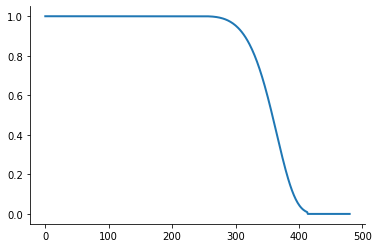

In [512]:
plt.plot(simul_full_1[3])

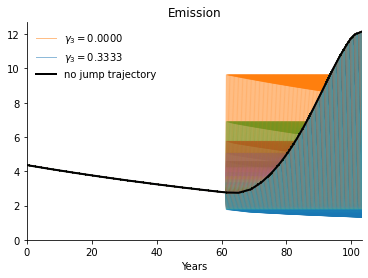

In [249]:
ems_test = simul_full_1[-1]
dt=1/4

Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_full_1[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

(1.1, 3.0)

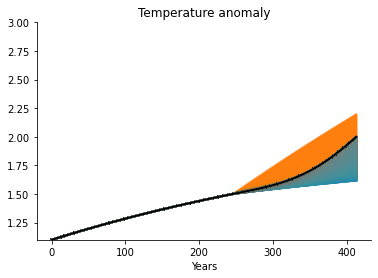

In [250]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(simul_full_1[-5][i, :len(simul_full_1[0])], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(simul_full_1[1], color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

(0.0, 1.0495415728444324)

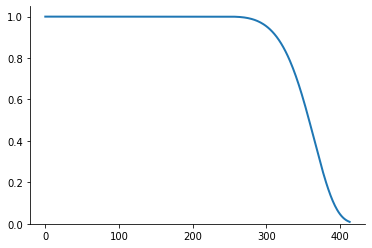

In [251]:
plt.plot(simul_full_1[3][:len(yt)])
plt.ylim(0)

In [252]:
simul_full_1[3], simul_full_1[-2][1], simul_full_1[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = simul_full_1[-4][:,-1]

prob_test.sum()

0.990831456888649

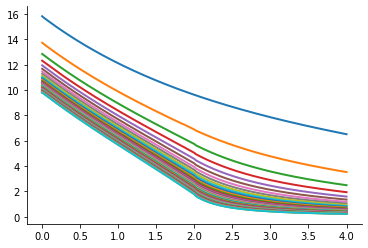

In [253]:
plt.plot(y_grid, ems_list.T)
plt.show()

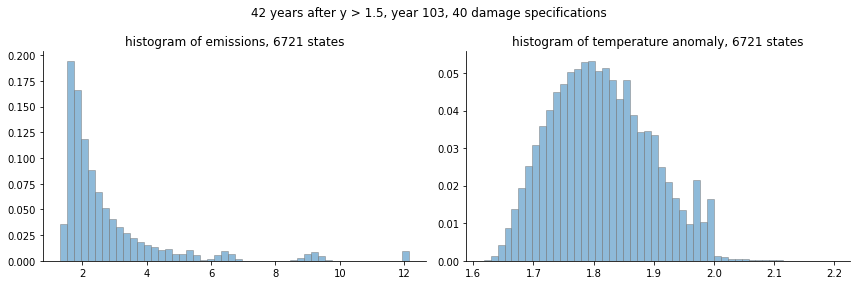

In [513]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
# Periods = int(60*4)
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-5][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt) ,int(t*dt), len(dmg_weight)))
(n, bins, patches) = axes[0].hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=50,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

# p = axes[0].patches

# distribution = np.zeros(len(p))
# for i in range(len(p)):
#     distribution[i] = p[i].get_height()

# bins = np.array([patch.get_xy()[0] for patch in p])

axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
plt.savefig("../figures/20_damages/hist_ems_y_{}_{}.png".format(ξa, ξp), dpi=500)
plt.show()

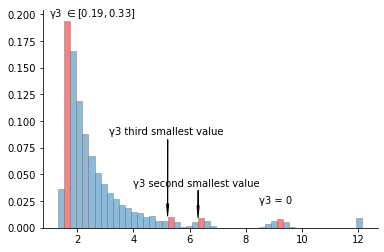

In [514]:
(n, bins, patches) = plt.hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")

patches[1].set_facecolor('r')

plt.annotate(r"γ3 $\in [0.19, 0.33] $ ",
               xy = (bins[1]+1, distribution[1]),             # top left corner of the histogram bar
               xytext = (0.1,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[18].set_facecolor('r')
plt.annotate(r"γ3 third smallest value ",
               xy = (bins[18], distribution[18]),             # top left corner of the histogram bar
               xytext = (0.1,80),  
                arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
patches[23].set_facecolor('r')
plt.annotate(r"γ3 second smallest value ",
               xy = (bins[23], distribution[23]),             # top left corner of the histogram bar
               xytext = (0.1,30), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[36].set_facecolor('r')
plt.annotate(r"γ3 = 0 ",
               xy = (bins[36], distribution[36]),             # top left corner of the histogram bar
               xytext = (0.1,13),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
             )
plt.savefig('emission.png', dpi=500)
plt.show()

In [290]:
distribution = np.zeros(len(patches))
for i in range(len(patches)):
    distribution[i] = patches[i].get_height()

In [310]:
bins[:],distribution[:]

(array([ 1.32066824,  1.53712205,  1.75357585,  1.97002965,  2.18648346,
         2.40293726,  2.61939107,  2.83584487,  3.05229867,  3.26875248,
         3.48520628,  3.70166008,  3.91811389,  4.13456769,  4.3510215 ,
         4.5674753 ,  4.7839291 ,  5.00038291,  5.21683671,  5.43329051,
         5.64974432,  5.86619812,  6.08265193,  6.29910573,  6.51555953,
         6.73201334,  6.94846714,  7.16492094,  7.38137475,  7.59782855,
         7.81428236,  8.03073616,  8.24718996,  8.46364377,  8.68009757,
         8.89655137,  9.11300518,  9.32945898,  9.54591279,  9.76236659,
         9.97882039, 10.1952742 , 10.411728  , 10.6281818 , 10.84463561,
        11.06108941, 11.27754322, 11.49399702, 11.71045082, 11.92690463,
        12.14335843]),
 array([3.62314836e-02, 1.94135940e-01, 1.65623139e-01, 1.18495086e-01,
        8.78794480e-02, 6.69783350e-02, 5.16638010e-02, 4.08207744e-02,
        3.28713750e-02, 2.67729815e-02, 2.18422245e-02, 1.83822392e-02,
        1.51700880e-02, 1.35841

In [347]:
γ3_list[22:]

array([0.18632369, 0.19489694, 0.20347938, 0.21207104, 0.22067194,
       0.2292821 , 0.23790153, 0.24653026, 0.25516831, 0.26381569,
       0.27247243, 0.28113855, 0.28981407, 0.298499  , 0.30719338,
       0.31589721, 0.32461052, 0.33333333])

In [344]:
indices = np.where((ems_110 > bins[1]) & (ems_110 < bins[2]))[0]
print(np.unique((indices-1)%40))
for i in range(len(indices)):
    print((indices[i]-1)/40*dt)

for i in range(len(indices)):
    print(int((indices[i]-1)/40)*dt)

[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
0.1375
0.14375
0.15
0.15625
0.1625
0.16875
0.175
0.3875
0.39375
0.4
0.40625
0.4125
0.41875
0.425
0.6375
0.64375
0.65
0.65625
0.6625
0.66875
0.675
0.8875
0.89375
0.9
0.90625
0.9125
0.91875
0.925
1.1375
1.14375
1.15
1.15625
1.1625
1.16875
1.175
1.3875
1.39375
1.4
1.40625
1.4125
1.41875
1.425
1.6375
1.64375
1.65
1.65625
1.6625
1.66875
1.675
1.8875
1.89375
1.9
1.90625
1.9125
1.91875
1.925
2.1375
2.14375
2.15
2.15625
2.1625
2.16875
2.175
2.18125
2.39375
2.4
2.40625
2.4125
2.41875
2.425
2.43125
2.64375
2.65
2.65625
2.6625
2.66875
2.675
2.68125
2.89375
2.9
2.90625
2.9125
2.91875
2.925
2.93125
3.14375
3.15
3.15625
3.1625
3.16875
3.175
3.18125
3.39375
3.4
3.40625
3.4125
3.41875
3.425
3.43125
3.64375
3.65
3.65625
3.6625
3.66875
3.675
3.68125
3.89375
3.9
3.90625
3.9125
3.91875
3.925
3.93125
4.14375
4.15
4.15625
4.1625
4.16875
4.175
4.18125
4.39375
4.4
4.40625
4.4125
4.41875
4.425
4.43125
4.64375
4.65
4.65625
4.6625
4.66875
4.675
4.68125
4.89

[2]


(array([4., 3., 3., 3., 3., 4., 3., 3., 3., 4.]),
 array([21.0125, 21.8125, 22.6125, 23.4125, 24.2125, 25.0125, 25.8125,
        26.6125, 27.4125, 28.2125, 29.0125]),
 <BarContainer object of 10 artists>)

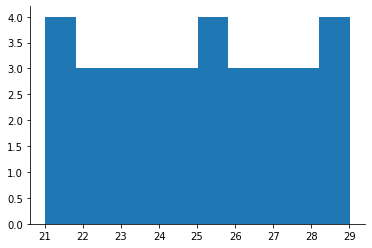

In [474]:
indices = np.where((ems_110 >= bins[18]) & (ems_110 <= bins[19]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [475]:
indices = np.where((ems_110 >= bins[23]) & (ems_110 <= bins[24]))[0]
print(np.unique((indices-1)%40))
print(np.array((indices-1)/40, dtype=int)*dt)

[1]
[19.   19.25 19.5  19.75 20.   20.25 20.5  20.75 21.   21.25 21.5  21.75
 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75 24.   24.25 24.5  24.75
 25.   25.25 25.5  25.75 26.   26.25]


[0]


(array([3., 3., 2., 3., 2., 3., 3., 2., 3., 3.]),
 array([19.25, 19.9 , 20.55, 21.2 , 21.85, 22.5 , 23.15, 23.8 , 24.45,
        25.1 , 25.75]),
 <BarContainer object of 10 artists>)

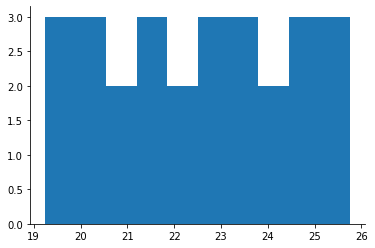

In [476]:
indices = np.where((ems_110 >= bins[36]) & (ems_110 <= bins[37]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

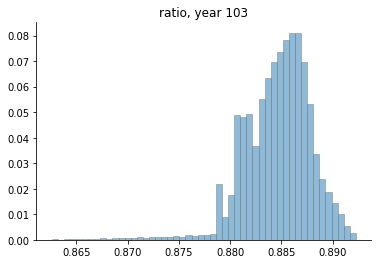

In [256]:
plt.hist(simul_full_1[5][1:,len(simul_full_1[0])], weights=simul_full_1[-4][1:,len(simul_full_1[0])],
         bins=50,
         alpha=0.5, ec="gray",)
plt.title("ratio, year {:d}".format(int(t*dt)))
plt.savefig("../figures/20_damages/ratio_{}_{}.png".format(ξa, ξp), dpi=500)

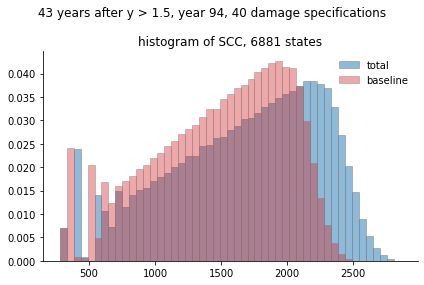

In [428]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]

me_110 = simul_full_1[4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

scc = η/ems_110/MCt[t]*1000
scc0 = me_110/MCt[t]*1000

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(scc, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
             alpha=0.5, ec="gray", label="total")
axes.hist(scc0, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
              color="tab:red",
             alpha=0.4, ec="gray", label="baseline")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
axes.legend()
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
plt.savefig("../figures/20_damages/hist_scc_{}_{}.png".format(ξa, ξp), dpi=500)
# plt.show()

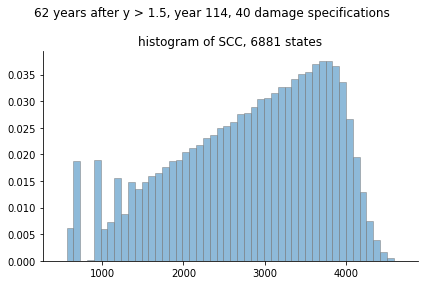

In [105]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 + 20*4
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int(t*dt-Periods*dt + (len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(η/ems_110/MCt[t]*1000, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("hist_scc_116.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-55, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
prob_110.sum()

In [ ]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]

plt.hist(ems_test[:, t], weights=prob_110, bins=np.linspace(0,12,20))
plt.hist(ems_110, weights=prob_110, bins=20)

In [ ]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])
ems_110 = simul_full_1[-1][:, t]
ems_test[:, t].max(), ems_110.max(), Periods, ems_test[41]

In [ ]:
plt.plot(ems_test[81, :447])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    ax1.plot(Time, η/ems_test[i, :Periods]/MCt[:Periods]*1000, 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)


ax1.plot(Time, η/simul_full_1[0]/MCt[:Periods]*1000, color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_1[0])*dt)
ax1.legend()

# plot2


ax2.hist(η/ems_110/MCt[t]*1000, weights=prob_110, 
#          bins=np.linspace(0,12,20),
         bins=50,
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])


# ax2.set_xlim(1,14)
# ax2.set_ylim(0,12)
# ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year {}".format(len(ems_110), t*dt))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
# plt.savefig("../figures/20_damages/emission_hist_new.png",facecolor="w", edgecolor="w", dpi=500)

In [ ]:
prob_110[0]

In [ ]:
len(simul_full_2[0])/4

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no2[0])-1
ems_110 = simul_full_2[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_2[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_2[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(simul_full_2[0])
ax1.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_2[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

# ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
# ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
#         ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 91".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_2.png",facecolor="w", edgecolor="w", dpi=1000)

In [630]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

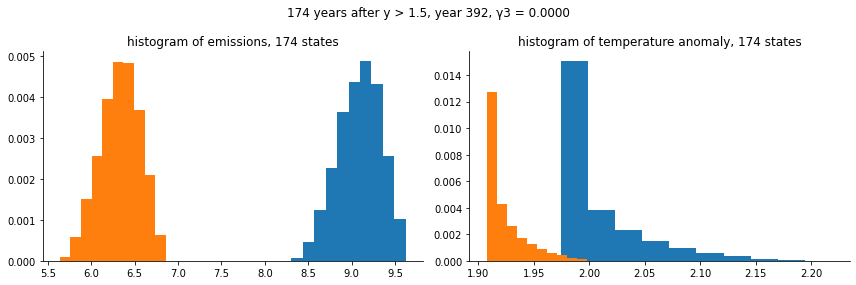

In [633]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [634]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

<ipython-input-635-4e19a4ee5b3f>:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


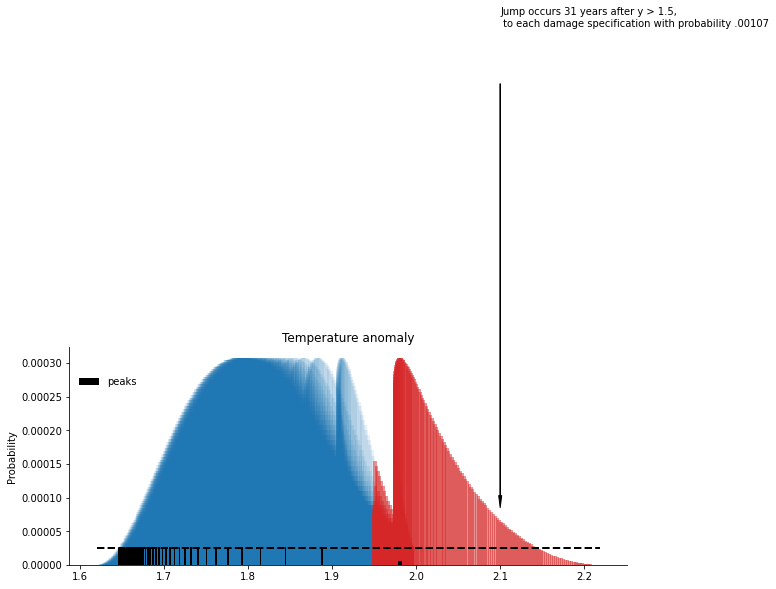

In [635]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')